# Imports

## Libraries

In [61]:
import geopandas as gpd
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import seaborn as sns
from shapely.ops import unary_union
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from benfordslaw import benfordslaw
from shapely.geometry import Point
import matplotlib.pyplot as plt

## Data

In [62]:
prov_gdf = gpd.read_file("../data/it_provinces_shapes.geojson", driver='geojson')
provinces_df = pd.read_csv("../data/provinces.csv", skipfooter=1)
provinces_gdf = gpd.read_file("../data/provinces_gdf.geojson", driver='geojson')

# Plotting the Data

## Population

### Boxplot of province populations

The Mean Province Population is 570758.0


<AxesSubplot:ylabel='Population'>

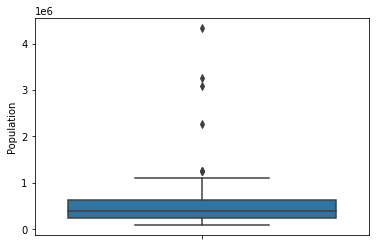

In [63]:
# most regions have around half a million
print(f"The Mean Province Population is {round(provinces_gdf.Population.mean(),0)}")
sns.boxplot(data = provinces_gdf, y='Population')

### Boxplot of province populations by Macroregion

<AxesSubplot:xlabel='Macroregion', ylabel='Population'>

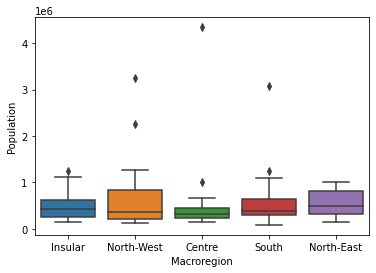

In [64]:
# all regions have major outliers except for Insular (Islands) and the North-East
sns.boxplot(data = provinces_gdf, x='Macroregion', y='Population')

### Simple Population Choropleth

<AxesSubplot:>

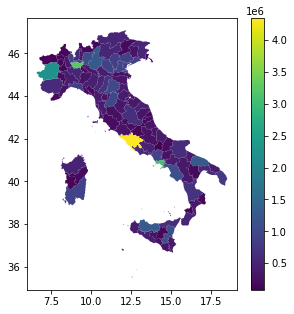

In [65]:
provinces_gdf.plot(column = 'Population', figsize=(5, 5), legend=True)

### Cartograms

#### Simple Cartogram

<GeoAxesSubplot:>

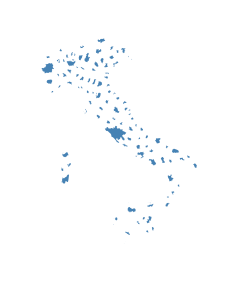

In [66]:
gplt.cartogram(provinces_gdf, scale='Population', projection=gcrs.AlbersEqualArea(), figsize=(5,5), )

#### Cartogram / Choropleth Map

<GeoAxesSubplot:>

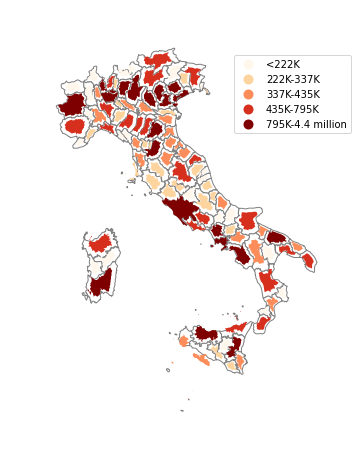

In [67]:
scheme = mc.Quantiles(provinces_gdf['Population'], k=5)
ax1 = gplt.cartogram(
    provinces_gdf, scale='Population', projection=gcrs.AlbersEqualArea(), figsize=(10, 8),
    legend=True, legend_kwargs={'bbox_to_anchor': (1, 0.9)}, legend_var='hue',
    hue='Population', scheme=scheme, cmap='OrRd', limits=(0.6, 1.1),
    legend_labels=[
        '<222K', '222K-337K', '337K-435K',
        '435K-795K', '795K-4.4 million'
    ]
)
gplt.polyplot(provinces_gdf, facecolor='white', edgecolor='grey', ax=ax1)

### How many provinces does it take to cover half of the population

In [68]:
provinces_gdf.Population.sum()

60500383

In [69]:
## sort by population
### iteratively add them until you have 30.2 million

In [70]:
provinces_gdf_pop_sort = provinces_gdf.sort_values(by='Population', ascending=False)

In [71]:
pop_sum = 0
counter = 0
total_pop = provinces_gdf.Population.sum()
for pop in provinces_gdf_pop_sort['Population']:
    if pop_sum < (total_pop / 2):
        pop_sum += pop
        counter += 1
    else:
        break

In [72]:
# you only need 22 provinces to reach half of the italian population
print(counter)
print(provinces_gdf.shape[0])

22
106


#### Displaying most populous regions only

<GeoAxesSubplot:>

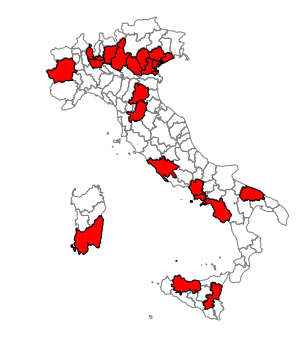

In [73]:
ax2 =  gplt.polyplot(provinces_gdf_pop_sort, projection=gcrs.AlbersEqualArea(), edgecolor = 'gray')
gplt.polyplot(
    provinces_gdf_pop_sort[0:21], projection=gcrs.AlbersEqualArea(), ax=ax2, facecolor='red'
)

#### What percent of the land area is needed to cover half of the population

In [81]:
# You only need 22.2 percent of the land to cover 50 percent of the population of Italy!
pct_of_land_half_pop = round(provinces_gdf_pop_sort[0:21].Area.sum() / \
                             provinces_gdf_pop_sort.Area.sum(), 3) * 100
print(pct_of_land_half_pop)

22.2


## Macroregions' Population

In general, Italy can be divided into 5 regions: North-East, North-West, Centre, South, and Insular (Islands). I would like to see how these regions appear on the map

In [56]:
macro_geometries = provinces_gdf.dissolve(by='Macroregion', aggfunc='sum')

### Cartogram

<GeoAxesSubplot:>

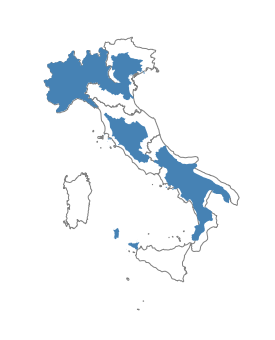

In [88]:
ax3 = gplt.cartogram(macro_geometries, scale='Population', projection=gcrs.AlbersEqualArea())
gplt.polyplot(macro_geometries, facecolor='white', edgecolor='grey', ax=ax3)

### Choropleth

<AxesSubplot:>

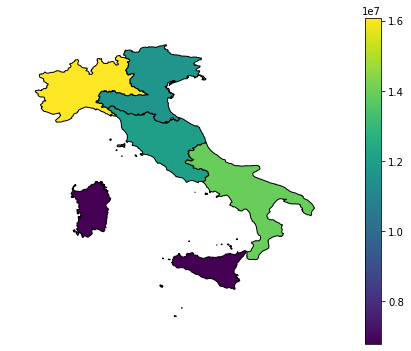

In [89]:
gplt.choropleth(macro_geometries, hue='Population', legend=True)

## Centroids

### Calculate centroid for each region in italy 
https://medium.com/@sumit.arora/plotting-weighted-mean-population-centroids-on-a-country-map-22da408c1397

- Steps to getting the population weighted mean centroid
    - find centroid for each province 
    - group the provinces into megaregions / whole of italy 
    - assign a weight (i.e.: the population) to each province
    - calculate weighted [longitude, latitude] 2-D point inside a megaregion / the country 
    - plot results

In [90]:
# the center of each province (since we don't have any more granular data)
provinces_gdf['Centroid_lat'] = [list(provinces_gdf.geometry[x].centroid.coords)[0][0] 
                                 for x in range(len(provinces_gdf))]
provinces_gdf['Centroid_lon'] = [list(provinces_gdf.geometry[x].centroid.coords)[0][1] 
                                 for x in range(len(provinces_gdf))]

#### Calculate mean centroid for each Region

In [211]:
# ynumerator = latitude multiplied by population
# xnumerator =  longitude multiplied by population 
## divide sum of x/y numberator by the sum of all weights in the megaregion/all of italy 

In [212]:
# so we need all of the weights before we start aggreggating the centroids

In [285]:
provinces_pop_sum = provinces_gdf.groupby('Region')['Population'].sum().to_dict()

In [288]:
# finding numerators for each region
weighted_lat_sum = {key:0 for key in provinces_pop_sum.keys()}
weighted_lon_sum = {key:0 for key in provinces_pop_sum.keys()}
for idx, x in provinces_gdf.iterrows():
    region = x['Region']
#     region_pop = province_pop_sums[region]
    
    weighted_lat_sum[region] += x['Centroid_lat'] * x['Population']
    weighted_lon_sum[region] += x['Centroid_lon'] * x['Population']

#multiply each value by the number of provinces in that region
province_prov_counts = provinces_gdf.groupby('Region')['Population'].count().to_dict()

for key, value in province_prov_counts.items():
    province_pop_sums[key] = province_pop_sums[key] * value
#weighted_lon_sum[key] = weighted_lon_sum[key] * value

In [302]:
# finding weighted lat and long for each region
weighted_mean_lat_lon = {key:[] for key in provinces_pop_sum.keys()}
for key, value in provinces_pop_sum.items():
#     print(f"Key = {key}, Value = {value}")
    weighted_mean_lat_lon[key] = [weighted_lat_sum[key] / value, weighted_lon_sum[key] / value]
#     weighted_mean_lat_lon[key].append(weighted_lon_sum[key] / value)

In [290]:
weighted_mean_lat_lon['Abruzzo']

[13.950052455232992, 42.28685375297654]

In [291]:
region_weighted_centroid_df = pd.DataFrame.from_dict(weighted_mean_lat_lon, orient='index', 
                                                     columns=['Lat_weighted_centroid', "Lon_weighted_centroid"])

In [292]:
region_weighted_centroid_df['Centroid_Coords'] = list(zip(region_weighted_centroid_df['Lat_weighted_centroid'], 
                                                   region_weighted_centroid_df['Lon_weighted_centroid']))
region_weighted_centroid_df['geometry'] = [Point(x) for x in region_weighted_centroid_df['Centroid_Coords']]
region_weighted_centroid_gdf = gpd.GeoDataFrame(region_weighted_centroid_df)

<AxesSubplot:>

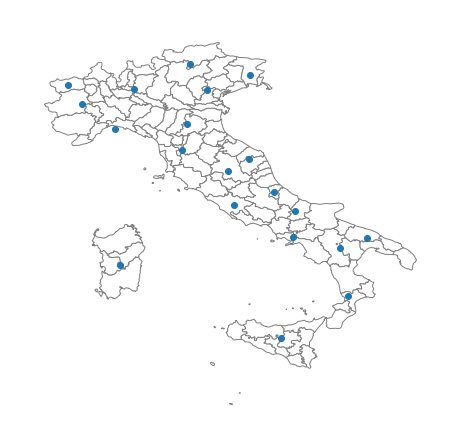

In [295]:
ax5 = region_weighted_centroid_gdf.plot(figsize=(8,8))
gplt.polyplot(provinces_gdf, facecolor='white', edgecolor='grey', ax=ax5, figsize=(8,8))

#### Attempt with all of italy

In [299]:
provinces_gdf['Country'] = 'Italy'

In [320]:
provinces_gdf.head()

,Code,name,Province,Region,Macroregion,Population (2019)[3],Area(km²),Density(p/km²),Population,Area,Density,geometry,Centroid_lat,Centroid_lon,Country,Lat_times_weight,Lon_times_weight
0,AG,Agrigento,Agrigento,Sicily,Insular,"434,870","3,053",144,434870,3053,144,"MULTIPOLYGON (((12.62176 35.50975, 12.62127 35...",13.504662,37.432912,Italy,5.872772e+06,1.627845e+07
1,AL,Alessandria,Alessandria,Piedmont,North-West,"421,284","3,559",119,421284,3559,119,"POLYGON ((8.40472 45.20452, 8.49710 45.19799, ...",8.662525,44.831472,Italy,3.649383e+06,1.888678e+07
2,AN,Ancona,Ancona,Marche,Centre,"471,228","1,963",241,471228,1963,241,"POLYGON ((13.17721 43.75152, 13.25327 43.70319...",13.154161,43.504727,Italy,6.198609e+06,2.050065e+07
3,AO,Aoste,Aosta,Aosta Valley,North-West,"125,666","3,261",39,125666,3261,39,"POLYGON ((7.02208 45.92526, 7.06694 45.89022, ...",7.370982,45.730169,Italy,9.262818e+05,5.746727e+06
4,AP,Ascoli Piceno,Ascoli Piceno,Marche,Centre,"207,179","1,228",170,207179,1228,170,"POLYGON ((13.85349 43.06736, 13.86541 43.00731...",13.551915,42.888788,Italy,2.807672e+06,8.885656e+06


In [307]:
provinces_gdf['Lat_times_weight'] = provinces_gdf['Centroid_lat'] * provinces_gdf['Population']
provinces_gdf['Lon_times_weight'] = provinces_gdf['Centroid_lon'] * provinces_gdf['Population']

In [308]:
provinces_gdf_country_sum = provinces_gdf.groupby('Country')['Population', 'Lat_times_weight', 'Lon_times_weight'].sum()

In [309]:
provinces_gdf_country_sum['Lat_centroid'] = provinces_gdf_country_sum['Lat_times_weight'] / \
                                                provinces_gdf_country_sum['Population']
provinces_gdf_country_sum['Lon_centroid'] = provinces_gdf_country_sum['Lon_times_weight'] / \
                                                provinces_gdf_country_sum['Population']

In [310]:
provinces_gdf_country_sum['Centroid_Coords'] = list(zip(provinces_gdf_country_sum['Lat_centroid'], 
                                                   provinces_gdf_country_sum['Lon_centroid']))
provinces_gdf_country_sum['geometry'] = [Point(x) for x in provinces_gdf_country_sum['Centroid_Coords']]

In [312]:
type(provinces_gdf_country_sum)

pandas.core.frame.DataFrame

In [313]:
provinces_gdf_country_sum_gdf = gpd.GeoDataFrame(provinces_gdf_country_sum, geometry='geometry')

In [319]:
# values are slightly different than previous approach
provinces_gdf_country_sum_gdf.head(2)

,Population,Lat_times_weight,Lon_times_weight,Lat_centroid,Lon_centroid,Centroid_Coords,geometry
Country,,,,,,,
Italy,60500383,7.297516e+08,2.597829e+09,12.061933,42.939056,"(12.061933242704367, 42.93905581590078)",POINT (12.06193 42.93906)


In [317]:
italy_geometry = provinces_gdf.dissolve(by='Country')

In [330]:
geo_center_of_italy = italy_geometry.centroid
geo_center_of_italy

Country
Italy    POINT (12.07191 42.78643)
dtype: geometry

<AxesSubplot:>

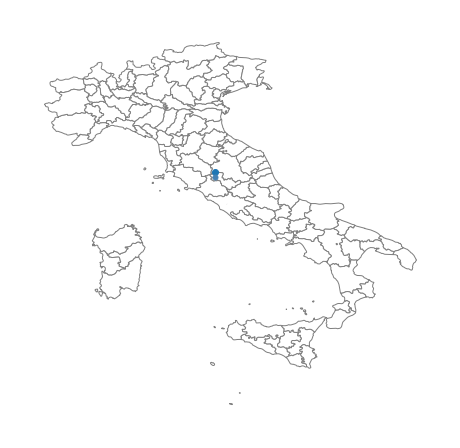

In [329]:
ax5 = provinces_gdf_country_sum_gdf.plot(figsize=(8,8))
# italy_geometry.plot(geometry = 'Geographic_center', ax=ax5, figsize=(8,8))
gplt.pointplot(geo_center_of_italy, ax=ax5)
gplt.polyplot(provinces_gdf, facecolor='white', edgecolor='grey', ax=ax5, figsize=(8,8))

#### Previously here

In [297]:
provinces_gdf_region_sum['Lat_times_weight'] = provinces_gdf_region_sum['Centroid_lat'] * provinces_gdf_region_sum['Population']
provinces_gdf_region_sum['Lon_times_weight'] = provinces_gdf_region_sum['Centroid_lon'] * provinces_gdf_region_sum['Population']

KeyError: 'Centroid_lat'

In [447]:
provinces_data_gdf_region_sum['Lat_centroid'] = provinces_data_gdf_region_sum['Lat_times_weight'] / \
                                                provinces_data_gdf_region_sum['Population']
provinces_data_gdf_region_sum['Lon_centroid'] = provinces_data_gdf_region_sum['Lon_times_weight'] / \
                                                provinces_data_gdf_region_sum['Population']

In [448]:
provinces_data_gdf_region_sum['Centroid_Coords'] = list(zip(provinces_data_gdf_region_sum['Lat_centroid'], 
                                                   provinces_data_gdf_region_sum['Lon_centroid']))
provinces_data_gdf_region_sum['geometry'] = [Point(x) for x in provinces_data_gdf_region_sum['Centroid_Coords']]

In [450]:
type(provinces_data_gdf_region_sum)

pandas.core.frame.DataFrame

In [453]:
provinces_data_gdf_region_sum_gdf = gpd.GeoDataFrame(provinces_data_gdf_region_sum, geometry='geometry')

In [454]:
provinces_data_gdf_region_sum_gdf.head(2)

,Population,Lat_times_weight,Lon_times_weight,Lat_centroid,Lon_centroid,Centroid_Coords,geometry
Region,,,,,,,
Abruzzo,1311580.0,1.829661e+07,5.546259e+07,13.950052,42.286854,"(13.950052455232992, 42.28685375297654)",POINT (13.95005 42.28685)
Aosta Valley,125666.0,9.262818e+05,5.746727e+06,7.370982,45.730169,"(7.37098173797981, 45.730168877636494)",POINT (7.37098 45.73017)


In [460]:
region_geometries = provinces_data_gdf.dissolve(by='Region')

#### Plot

<AxesSubplot:>

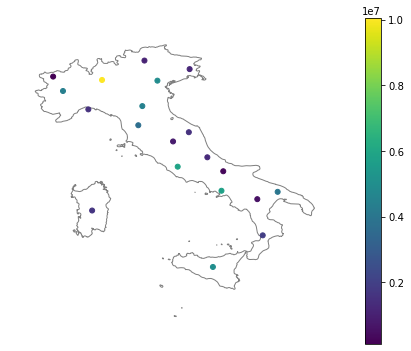

In [537]:
ax5 = gplt.pointplot(provinces_data_gdf_region_sum_gdf, hue='Population', legend=True)
gplt.polyplot(region_geometries, facecolor='white', edgecolor='grey', ax=ax5)

### Calculating Centroid for Italy

In [463]:
provinces_data_gdf['Country'] = 'Italy'

In [468]:
provinces_data_gdf_italy_sum = provinces_data_gdf.groupby('Country')['Population', 'Lat_times_weight', 'Lon_times_weight'].sum()

In [470]:
provinces_data_gdf_italy_sum['Lat_centroid'] = provinces_data_gdf_italy_sum['Lat_times_weight'] / \
                                                provinces_data_gdf_italy_sum['Population']
provinces_data_gdf_italy_sum['Lon_centroid'] = provinces_data_gdf_italy_sum['Lon_times_weight'] / \
                                                provinces_data_gdf_italy_sum['Population']

In [472]:
provinces_data_gdf_italy_sum['Centroid_Coords'] = list(zip(provinces_data_gdf_italy_sum['Lat_centroid'], 
                                                   provinces_data_gdf_italy_sum['Lon_centroid']))
provinces_data_gdf_italy_sum['geometry'] = [Point(x) for x in provinces_data_gdf_italy_sum['Centroid_Coords']]

In [474]:
provinces_data_gdf_italy_sum_gdf = gpd.GeoDataFrame(provinces_data_gdf_italy_sum, geometry='geometry')

In [475]:
provinces_data_gdf_italy_sum_gdf.head(2)

,Population,Lat_times_weight,Lon_times_weight,Lat_centroid,Lon_centroid,Centroid_Coords,geometry
Country,,,,,,,
Italy,60359537.0,7.284738e+08,2.592268e+09,12.068909,42.947114,"(12.068908881248918, 42.94711438129831)",POINT (12.06891 42.94711)


In [478]:
italy_geometry = provinces_data_gdf.dissolve(by='Country')

#### Plot

<AxesSubplot:>

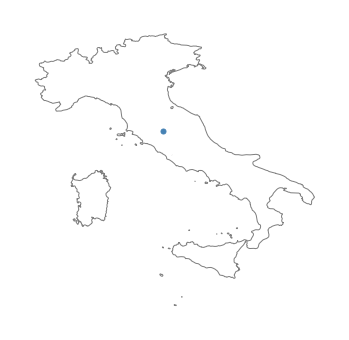

In [479]:
ax6 = gplt.pointplot(provinces_data_gdf_italy_sum_gdf)

gplt.polyplot(italy_geometry, facecolor='white', edgecolor='grey', ax=ax6)

<AxesSubplot:>

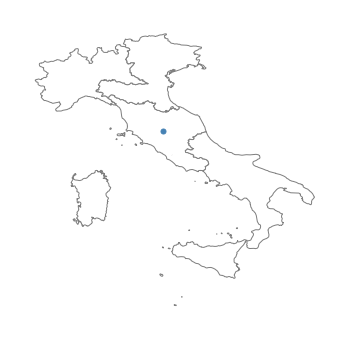

In [480]:
ax7 = gplt.pointplot(provinces_data_gdf_italy_sum_gdf)
gplt.polyplot(macro_geometries, facecolor='white', edgecolor='grey', ax=ax7)

##### Find which region this point lands in

In [494]:
only_flor = provinces_data_gdf[provinces_data_gdf['name'] == 'Firenze']
only_flor

,Code,geometry,adm1_code,iso_3166_2,name,gns_region,Type,Province,Region,Macroregion,...,Density(p/km²),Population_no_commas,Population,Centroid,Centroid_coords,Centroid_lat,Centroid_lon,Lat_times_weight,Lon_times_weight,Country
33,FI,"POLYGON ((10.79348 43.71898, 10.79333 43.71938...",ITA-5386,IT-FI,Firenze,IT16,M,Florence,Tuscany,Centre,...,284,1011349,1011349.0,POINT (11.29259 43.82028),"(11.292592898159588, 43.82028100757583)",11.292593,43.820281,1.142075e+07,4.431760e+07,Italy


<AxesSubplot:>

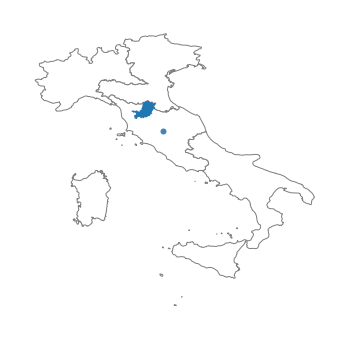

In [496]:
ax7 = gplt.pointplot(provinces_data_gdf_italy_sum_gdf)
only_flor.plot(ax=ax7)
gplt.polyplot(macro_geometries, facecolor='white', edgecolor='grey', ax=ax7)

In [507]:
center_of_italy = provinces_data_gdf_italy_sum_gdf.geometry.values[0]

In [509]:
center_of_italy.within(only_flor['geometry'].iloc[0])

False

In [503]:
provinces_data_gdf.head(2)

,Code,geometry,adm1_code,iso_3166_2,name,gns_region,Type,Province,Region,Macroregion,...,Density(p/km²),Population_no_commas,Population,Centroid,Centroid_coords,Centroid_lat,Centroid_lon,Lat_times_weight,Lon_times_weight,Country
0,AG,"MULTIPOLYGON (((12.62176 35.50975, 12.62127 35...",ITA-5417,IT-AG,Agrigento,IT15,F,Agrigento,Sicily,Insular,...,144,434870,434870.0,POINT (13.50466 37.43291),"(13.504662008710852, 37.43291246547851)",13.504662,37.432912,5.872772e+06,1.627845e+07,Italy
1,AL,"POLYGON ((8.40472 45.20452, 8.49710 45.19799, ...",ITA-5439,IT-AL,Alessandria,IT12,O,Alessandria,Piedmont,North-West,...,119,421284,421284.0,POINT (8.66253 44.83147),"(8.662525276248699, 44.83147193153259)",8.662525,44.831472,3.649383e+06,1.888678e+07,Italy


In [504]:
provinces_data_gdf['Macroregion'].unique()

array(['Insular', 'North-West', 'Centre', 'South', 'North-East'],
      dtype=object)

In [510]:
# the mean population center of italy is within perugia
for index,x in provinces_data_gdf.iterrows():
    if x['Macroregion'] == 'Centre':
        if center_of_italy.within(x['geometry']):
            print(x['name'])

Perugia


#### Actual centroid

In [559]:
italy_geo_centroid = italy_geometry.centroid

In [560]:
type(italy_geo_centroid)

geopandas.geoseries.GeoSeries

<AxesSubplot:>

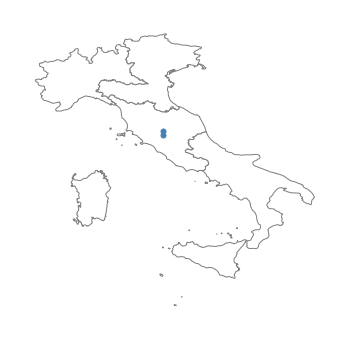

In [561]:
ax8 = gplt.pointplot(provinces_data_gdf_italy_sum_gdf)
gplt.pointplot(italy_geo_centroid, ax=ax8)
gplt.polyplot(macro_geometries, facecolor='white', edgecolor='grey', ax=ax8)

<AxesSubplot:>

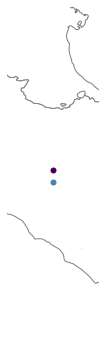

In [562]:
ax10 = gplt.polyplot(macro_geometries, facecolor='white', edgecolor='grey')
gplt.pointplot(italy_geo_centroid, ax=ax10)
gplt.pointplot(provinces_data_gdf_italy_sum_gdf, ax=ax10, hue='Population')

#### Megaregions Centroids

In [580]:
provinces_data_gdf

,Code,geometry,adm1_code,iso_3166_2,name,gns_region,Type,Province,Region,Macroregion,...,Density(p/km²),Population_no_commas,Population,Centroid,Centroid_coords,Centroid_lat,Centroid_lon,Lat_times_weight,Lon_times_weight,Country
0,AG,"MULTIPOLYGON (((12.62176 35.50975, 12.62127 35...",ITA-5417,IT-AG,Agrigento,IT15,F,Agrigento,Sicily,Insular,...,144,434870,434870.0,POINT (13.50466 37.43291),"(13.504662008710852, 37.43291246547851)",13.504662,37.432912,5.872772e+06,1.627845e+07,Italy
1,AL,"POLYGON ((8.40472 45.20452, 8.49710 45.19799, ...",ITA-5439,IT-AL,Alessandria,IT12,O,Alessandria,Piedmont,North-West,...,119,421284,421284.0,POINT (8.66253 44.83147),"(8.662525276248699, 44.83147193153259)",8.662525,44.831472,3.649383e+06,1.888678e+07,Italy
2,AN,"POLYGON ((13.17721 43.75152, 13.25327 43.70319...",ITA-5427,IT-AN,Ancona,IT10,O,Ancona,Marche,Centre,...,241,471228,471228.0,POINT (13.15416 43.50473),"(13.154160652670816, 43.50472707658491)",13.154161,43.504727,6.198609e+06,2.050065e+07,Italy
3,AO,"POLYGON ((7.02208 45.92526, 7.06694 45.89022, ...",ITA-5442,IT-AO,Aoste,IT19,D,Aosta,Aosta Valley,North-West,...,39,125666,125666.0,POINT (7.37098 45.73017),"(7.37098173797981, 45.730168877636494)",7.370982,45.730169,9.262818e+05,5.746727e+06,Italy
4,AP,"POLYGON ((13.85349 43.06736, 13.86541 43.00731...",ITA-5431,IT-AP,Ascoli Piceno,None,O,Ascoli Piceno,Marche,Centre,...,170,207179,207179.0,POINT (13.55191 42.88879),"(13.551914689104773, 42.88878796122855)",13.551915,42.888788,2.807672e+06,8.885656e+06,Italy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,VE,"MULTIPOLYGON (((12.19939 45.27460, 12.20191 45...",ITA-5461,IT-VE,Venezia,IT20,M,Venice,Veneto,North-East,...,351,853338,853338.0,POINT (12.48068 45.52851),"(12.48068391553662, 45.528508145950774)",12.480684,45.528508,1.065024e+07,3.885121e+07,Italy
102,VI,"POLYGON ((11.18383 45.62014, 11.17523 45.62199...",ITA-5465,IT-VI,Vicenza,IT20,O,Vicenza,Veneto,North-East,...,320,862418,862418.0,POINT (11.49242 45.67302),"(11.492417948943437, 45.673022527616716)",11.492418,45.673023,9.911268e+06,3.938924e+07,Italy
103,VR,"POLYGON ((11.13072 45.69959, 11.15078 45.67254...",ITA-5464,IT-VR,Verona,IT20,O,Verona,Veneto,North-East,...,295,926497,926497.0,POINT (11.03767 45.41973),"(11.037670295854674, 45.419731060108276)",11.037670,45.419731,1.022637e+07,4.208124e+07,Italy
104,VT,"POLYGON ((11.73982 42.15994, 11.73618 42.16889...",ITA-5423,IT-VT,Viterbo,IT07,O,Viterbo,Lazio,Centre,...,89,317030,317030.0,POINT (11.99264 42.42531),"(11.992641371858117, 42.42530584557113)",11.992641,42.425306,3.802027e+06,1.345009e+07,Italy


In [577]:
provinces_data_gdf_macroregion_sum = provinces_data_gdf.groupby('Macroregion')['Population', 'Lat_times_weight', 'Lon_times_weight'].sum()

In [579]:
provinces_data_gdf_macroregion_sum['Lat_centroid'] = provinces_data_gdf_macroregion_sum['Lat_times_weight'] / \
                                                provinces_data_gdf_macroregion_sum['Population']
provinces_data_gdf_macroregion_sum['Lon_centroid'] = provinces_data_gdf_macroregion_sum['Lon_times_weight'] / \
                                                provinces_data_gdf_macroregion_sum['Population']

In [578]:
provinces_data_gdf_macroregion_sum.head()

,Population,Lat_times_weight,Lon_times_weight
Macroregion,,,
Centre,12016009.0,1.467067e+08,5.130939e+08
Insular,6639482.0,8.574877e+07,2.536446e+08
North-East,11652827.0,1.359417e+08,5.275414e+08
North-West,16093277.0,1.437698e+08,7.296438e+08
South,13957942.0,2.163068e+08,5.683444e+08


In [553]:
provinces_data_gdf_macroregion_sum['Centroid_Coords'] = list(zip(provinces_data_gdf_macroregion_sum['Lat_centroid'], 
                                                   provinces_data_gdf_macroregion_sum['Lon_centroid']))
provinces_data_gdf_macroregion_sum['geometry'] = [Point(x) for x in provinces_data_gdf_macroregion_sum['Centroid_Coords']]

In [554]:
provinces_data_gdf_macroregion_sum_gdf = gpd.GeoDataFrame(provinces_data_gdf_macroregion_sum, geometry='geometry')

In [571]:
region_centroid = provinces_data_gdf_macroregion_sum_gdf.drop(columns=['geometry'])
region_centroid['geometry'] = [x.centroid for x in provinces_data_gdf_macroregion_sum_gdf.geometry]

In [572]:
type(region_centroid)

geopandas.geodataframe.GeoDataFrame

<AxesSubplot:>

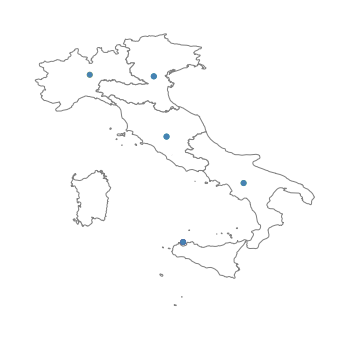

In [576]:
ax11 = gplt.pointplot(provinces_data_gdf_macroregion_sum_gdf, hue='Population')
gplt.pointplot(region_centroid, ax=ax11)
gplt.polyplot(macro_geometries, facecolor='white', edgecolor='grey', ax=ax11)

In [ ]:
# find actual centroids of each region